In [1]:
!pip install emoji
!pip install soynlp
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 6.6 MB/s eta 0:00:00a 0:00:01


In [2]:
from datasets import load_dataset

hatescore_dataset = load_dataset('smilegate-ai/kor_unsmile')

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/smilegate-ai--kor_unsmile-e0f75c6e3be1af78/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import pandas as pd

text_list = []
label_list = []
for tmp_dict in hatescore_dataset['train']:
  text_list.append(tmp_dict['문장'])
  tmp_label = []
  for tmp_key in list(tmp_dict.keys()):
    if tmp_key != '문장' and tmp_dict[tmp_key] == 1:
      tmp_label.append(tmp_key)
  label_list.append(tmp_label)

for tmp_dict in hatescore_dataset['valid']:
  text_list.append(tmp_dict['문장'])
  tmp_label = []
  for tmp_key in list(tmp_dict.keys()):
    if tmp_key != '문장' and tmp_dict[tmp_key] == 1:
      tmp_label.append(tmp_key)
  label_list.append(tmp_label)

hatescore_df = pd.DataFrame({
    'text' : text_list,
    'class': label_list
})

hatescore_df.to_excel('./hatescore.xlsx',index=False)
hatescore_df.sample(10)

,text,class
3880,토했어 ㅠㅠ,[clean]
2762,ㅇㄱㄹㅇ 자지새끼들 좆렬,[남성]
2989,목사새끼 남은 몇년만 더키우면 평생쓰는ATM기 ㅍㅌㅊ?,[종교]
11420,6만명 신상공개 적극 찬성한다,[clean]
18673,10분전에 '펄프픽션' 봤다질문받는다,[clean]
524,또 아니면 모... 알고 들어간거 맞죠?... 대박이든 쪽박이든 결과도 스스로 다 ...,[clean]
6777,웃기지마라. 나도 남잔데 페미니즘 공부해봤다. 학문중에서도 저급에 속하더라. 여성주...,[여성/가족]
9341,자적자는 잘했지만 보지찌른것보니 저새끼도 재기해야한다,[남성]
6236,벌레새끼나 저새끼 후장빨아주는 똥꼬충이나 죄다 챙놈이노,[성소수자]
9299,씨발 ㅋㅋㅋㅋㅋㅋㅋ 이준기사 보고 오오오.. 하다가 댓글보고 존나빡치네진짜 ㅋㅋㅋㅋ...,[악플/욕설]


In [4]:
def hatescore2df(df):
    hate_score_df = df

    def lambda_function(x):
        x = x[0]
        if x == '남성' or x == '여성/가족':
            return "남성/여성"
        else:
            return x

    # hate_score 에서 class label 하나인것만 가져오기 
    hate_score_df = hate_score_df[hate_score_df['class'].apply(lambda x: len(x) == 1)]
    hate_score_df['class'] = hate_score_df['class'].apply(lambda x: lambda_function(x) )
    hate_score_df.reset_index(drop=True, inplace=True)

    return hate_score_df

hatescore_df = hatescore2df(hatescore_df)
hatescore_df.sample(10)

/tmp/ipykernel_26/4169910563.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_score_df['class'] = hate_score_df['class'].apply(lambda x: lambda_function(x) )


,text,class
1495,"차별금지 좋지. 그런데 문제는 사람들이 안죽어. 예전에 퇴직금, 국민연금,부모 모시...",연령
1056,목련꽃이 피었다.,clean
7191,기자주말숙제. 한겨레 포폴쓰나?,악플/욕설
9387,봊나 멋지네ㅋㅋ같이 커버해주는 흑인련들까지 개사이다,인종/국적
1266,짐승들도 동성애는 안한다 인간이 어찌 이런 혐오스런 ㅜ 입에 담기도 더럽다,성소수자
11129,나랑 사귀자,clean
13730,여성혐오도 아니고 상식 비상식의 문제이다. 저게 한국사회의 약이되는거지 독이 될거라...,악플/욕설
4283,한국당 잘하고 있습니다! 좌파들 난리쳐도 어용언론이 제대로 보도도 하지 않고 있어도...,clean
14531,미친놈인가 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 전라도가 외국이지만 영어안써병신아 ㅋㅋㅋ...,지역
4486,서판교 운중동 게이다 울동네 맘충들은 조용하다 가끔 마을앞 카페에 종종 모여서 수다...,남성/여성


In [5]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

def text_preprocess(text):
    pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
    url_pattern = re.compile(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
 
    text = pattern.sub(' ', text)
    text = emoji.replace_emoji(text, replace='') #emoji 삭제
    text = url_pattern.sub('', text)
    text = text.strip()
    text = repeat_normalize(text, num_repeats=2)
    
    return text

hatescore_df['text'] = hatescore_df['text'].apply(lambda x: text_preprocess(x))
hatescore_df.head(10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,text,class
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,clean
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,종교
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵곡...,clean
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,clean
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,남성/여성
5,고향가서 피방가면 동네 부럴 친구들이랑은 뭐 거르는 거 없이 이야기하니까 막 말하게...,clean
6,나이쳐먹고 피시방가는 놈들은 대가리에 똥만찬 놈들임,악플/욕설
7,출산청같은 소리하네. 우리나라 계집들 다 의무적으로 군대보내면 해결될 일이다. 정신...,남성/여성
8,재능 ㅂㅅㅌㅊ노 ㅋㅋ나도 합성배우고싶다이기,clean
9,가짜 남자는 어떻게 생겼냐?,성소수자


In [6]:
class_change_dict = {
    "지역": 7, "종교":3, "인종/국적":2,
    "연령":4, "성소수자":6, "악플/욕설":5, "남성/여성": 1,
    "기타 혐오":8,'clean':0
}

hatescore_df['class'] = hatescore_df['class'].apply(lambda x: class_change_dict[x])
hatescore_df.head(10)

,text,class
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,3
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵곡...,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1
5,고향가서 피방가면 동네 부럴 친구들이랑은 뭐 거르는 거 없이 이야기하니까 막 말하게...,0
6,나이쳐먹고 피시방가는 놈들은 대가리에 똥만찬 놈들임,5
7,출산청같은 소리하네. 우리나라 계집들 다 의무적으로 군대보내면 해결될 일이다. 정신...,1
8,재능 ㅂㅅㅌㅊ노 ㅋㅋ나도 합성배우고싶다이기,0
9,가짜 남자는 어떻게 생겼냐?,6


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "beomi/KcELECTRA-small-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9, output_hidden_states=True)

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-small-v2022 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [8]:
batch_size =  32
learning_rate =  5e-5
num_epochs = 10
num_training_steps = 5000

In [9]:
from torch.utils.data import DataLoader, Dataset

# Custom Dataset 클래스
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        return text, label

my_dataset = MyDataset(hatescore_df)
train_dataloader = DataLoader(my_dataset, shuffle=True, batch_size=batch_size)

In [10]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [11]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    print(epoch)
    for texts, labels in train_dataloader:
        # make inputs
        inputs = tokenizer(texts, padding=True, return_tensors='pt')
        inputs['labels'] = torch.tensor(labels)
        
        inputs = {k: v.to(device) for k,v in inputs.items()}
        
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/5370 [00:00<?, ?it/s]

0


/tmp/ipykernel_26/950733730.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels)
/tmp/ipykernel_26/950733730.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels)


1
2
3
4
5
6
7
8
9


In [12]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model= model.to(device)
model.eval()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [13]:
# 임베딩을 저장할 리스트 초기화
embeddings = []

train_dataloader = DataLoader(my_dataset, shuffle=False, batch_size=batch_size)
# 데이터 로더를 통해 배치 단위로 처리
for texts, labgel in train_dataloader:
    inputs = tokenizer(texts, padding=True, return_tensors='pt')
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls_hidden_state = outputs.hidden_states[-1].cpu()
        mean_embedding = torch.mean(cls_hidden_state,dim=1).squeeze()
        embeddings.extend(mean_embedding)

In [17]:
my_df = pd.DataFrame({
  "sentence" : embeddings,
  "label": hatescore_df['class']
})
my_df.head()

,sentence,label
0,"[tensor(-0.6828), tensor(0.2443), tensor(0.244...",0
1,"[tensor(-0.4299), tensor(-0.3619), tensor(1.03...",3
2,"[tensor(-0.9352), tensor(0.1286), tensor(0.416...",0
3,"[tensor(-0.8438), tensor(0.2259), tensor(0.644...",0
4,"[tensor(-0.1653), tensor(0.4856), tensor(0.013...",1


In [18]:
import numpy as np
size = len(my_df)
matrix = np.zeros((size, 256))

for idx, vectors in enumerate(my_df['sentence']):
    vector = np.array(vectors)
    matrix[idx] =vector 

class_list = my_df['label']

In [19]:
import re
import emoji
import numpy as np 
import pandas as  pd
import seaborn as sns
import sys, re, argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager, rc

def visulize_sentences(title ,matrix, class_list, class_dict=None):
    
    vectors = matrix # 여기에 100차원 벡터 데이터를 입력하세요
    classes = class_list # 여기에 해당 벡터의 클래스 라벨(0에서 10 사이의 값)을 입력하세요
    
    if class_dict is not None:
        for idx, tmp_class in enumerate(classes):
            classes[idx] = class_dict[tmp_class]
        
    class_kind = len(set(classes))
    # t-SNE 임베딩 수행
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    vectors_tsne = tsne.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        x=vectors_tsne[:, 0], y=vectors_tsne[:, 1],
        hue=classes,
        palette=sns.color_palette("hsv", class_kind),
        legend="full",
        alpha=0.7
    )

    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')

/tmp/ipykernel_26/658824166.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes[idx] = class_dict[tmp_class]
/tmp/ipykernel_26/658824166.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'normal' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  classes[idx] = class_dict[tmp_class]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17154 samples in 0.004s...
[t-SNE] Computed neighbors for 17154 samples in 2.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17154
[t-SNE] Computed conditional probabilities for sample 2000 / 17154
[t-SNE] Computed conditional probabilities for sample 3000 / 17154
[t-SNE] Computed conditional probabilities for sample 4000 / 17154
[t-SNE] Computed conditional probabilities for sample 5000 / 17154
[t-SNE] Computed conditional probabilities for sample 6000 / 17154
[t-SNE] Computed conditional probabilities for sample 7000 / 17154
[t-SNE] Computed conditional probabilities for sample 8000 / 17154
[t-SNE] Computed conditional probabilities for sample 9000 / 17154
[t-SNE] Computed conditional probabilities for sample 10000 / 17154
[t-SNE] Computed conditional probabilities for sample 11000 / 17154
[t-SNE] Computed conditional probabilities for sample 12000 / 17154
[t-SNE] Computed conditional probabilities for sa

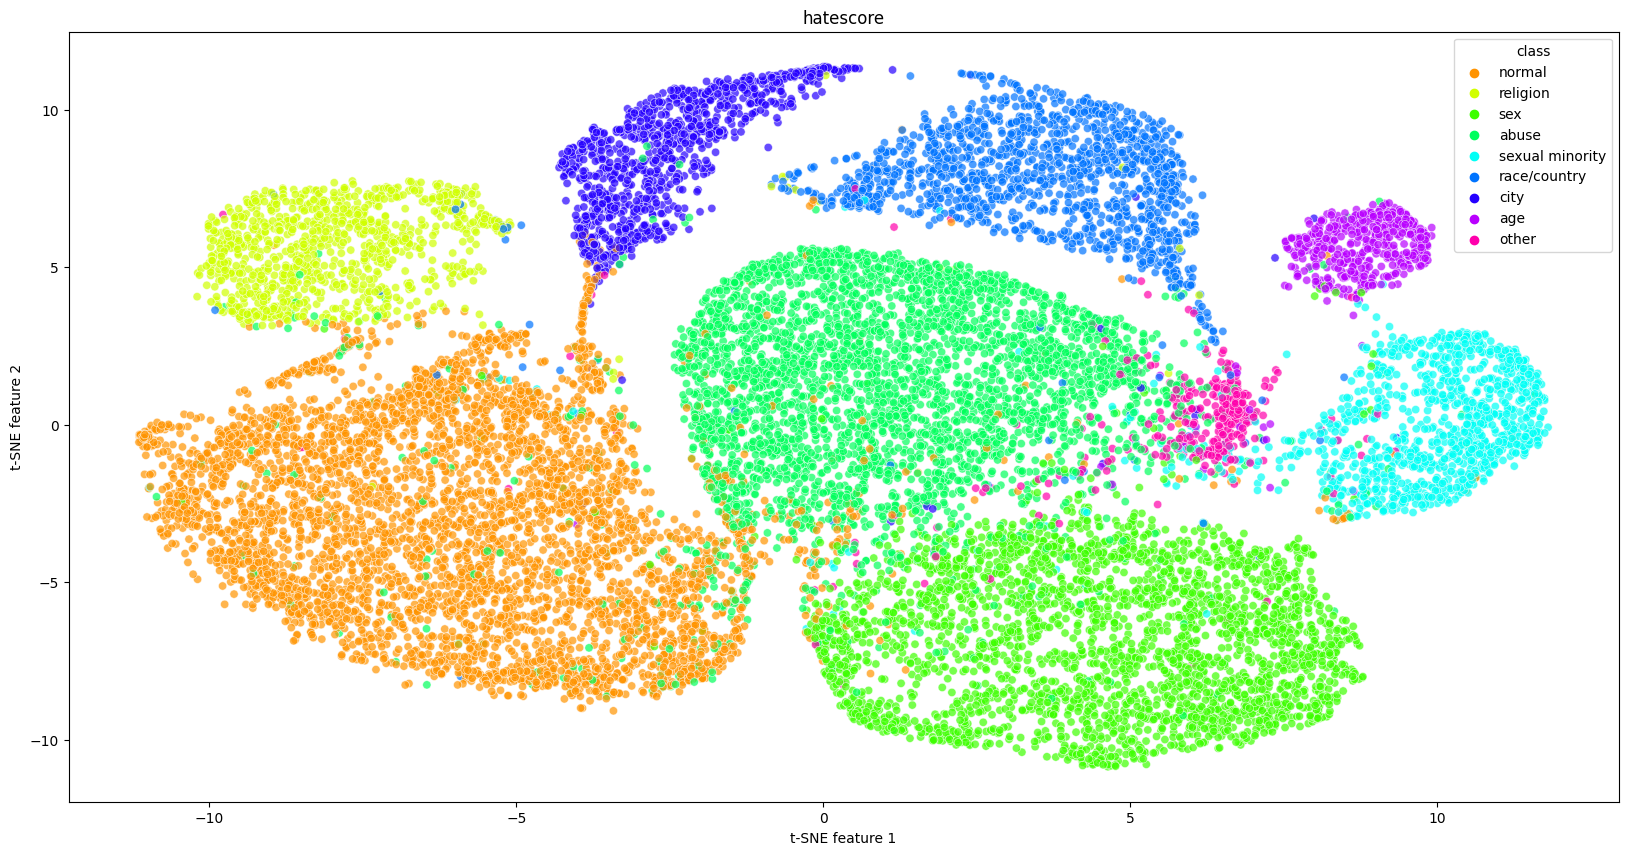

In [22]:
# class_change_dict = {
#     "지역": 7, "종교":3, "인종/국적":2,
#     "연령":4, "성소수자":6, "악플/욕설":5, "남성/여성": 1,
#     "기타 혐오":8,'clean':0
# }

class_list = hatescore_df['class']
visulize_sentences("hatescore",matrix, class_list, {
    0:"normal", 1:"sex", 2:"race/country",
    3:"religion", 4:"age", 5:"abuse",
    6:"sexual minority", 7: "city", 8: "other"
})